In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

from sklearn import preprocessing as pp
from sklearn.model_selection import KFold , cross_val_score
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score

%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns

# Aggregation of the data

We aggregate the data the same way we did it for the 1st exercices. So as before you can find the aggregation in the notebook HW04-1-Preprocessing.

Here we just load the CVS containing the aggregation already encoded

In [2]:
data_agr = pd.read_csv('CrowdstormingDataJuly1st_aggregated_encoded.csv')
data_agr.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,color_rating,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr,meanIAT_cards,meanExp_cards
0,0,392,34,0,360,182.0,71.0,1,654,247,179,228,9,19,0,0,166,37,0.346459,0.001505,0.494575,0.009691,1,0.328409,0.367721,0.333195,0.400637,0.0,0.0
1,1,393,91,2,176,183.0,73.0,0,336,141,73,122,62,42,0,1,99,25,0.348818,0.000834,0.449220,0.003823,2,0.329945,0.441615,0.341438,0.380811,0.0,0.0
2,2,394,83,0,719,165.0,63.0,11,412,200,97,115,31,11,0,0,101,28,0.345893,0.001113,0.491482,0.006350,2,0.328230,0.365628,0.332389,0.399459,0.0,0.0
3,3,395,6,0,1199,178.0,76.0,3,260,150,42,68,39,31,0,1,104,37,0.346821,0.003786,0.514693,0.015240,1,0.327775,0.412859,0.336638,0.433294,0.0,0.0
4,4,396,51,1,758,180.0,73.0,1,124,41,40,43,1,8,4,2,37,11,0.331600,0.000474,0.335587,0.001745,2,0.338847,0.379497,0.331882,0.328895,0.0,0.0


We drop the features that are unique to the players and we normalize them. That way all the features will be in [-1;1]. We also remove the color_ratings from the training data.

In [4]:
data_agr = data_agr.drop(['playerShort', 'player'], axis=1)
data_train = data_agr.drop(['color_rating'], axis=1)
colors = data_agr['color_rating']
col = data_train.columns
data_train = pd.DataFrame(pp.normalize(data_train))
data_train.columns = col
data_train.head()


,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr,meanIAT_cards,meanExp_cards
0,0.038720,0.000000,0.409981,0.207268,0.080857,0.001139,0.744799,0.281293,0.203852,0.259655,0.010250,0.021638,0.000000,0.000000,0.189047,0.042137,0.000395,1.714359e-06,0.000563,0.000011,0.000374,0.000419,0.000379,0.000456,0.0,0.0
1,0.183063,0.004023,0.354056,0.368138,0.146853,0.000000,0.675925,0.283647,0.146853,0.245425,0.124724,0.084491,0.000000,0.002012,0.199157,0.050292,0.000702,1.678514e-06,0.000904,0.000008,0.000664,0.000888,0.000687,0.000766,0.0,0.0
2,0.092819,0.000000,0.804062,0.184520,0.070453,0.012301,0.460742,0.223661,0.108476,0.128605,0.034667,0.012301,0.000000,0.000000,0.112949,0.031313,0.000387,1.244979e-06,0.000550,0.000007,0.000367,0.000409,0.000372,0.000447,0.0,0.0
3,0.004764,0.000000,0.951988,0.141329,0.060343,0.002382,0.206436,0.119098,0.033347,0.053991,0.030965,0.024614,0.000000,0.000794,0.082574,0.029377,0.000275,3.006309e-06,0.000409,0.000012,0.000260,0.000328,0.000267,0.000344,0.0,0.0
4,0.063901,0.001253,0.949745,0.225533,0.091466,0.001253,0.155367,0.051371,0.050118,0.053877,0.001253,0.010024,0.005012,0.002506,0.046360,0.013783,0.000415,5.936437e-07,0.000420,0.000002,0.000425,0.000475,0.000416,0.000412,0.0,0.0


## KMeans

In [5]:
from sklearn import metrics
from sklearn.cluster import KMeans
np.random.seed(1)

### assumption:
Since there are 5 variations of skin colors, there is no obvious choice of where to put the category 3. So we made the following choice. 
- categories 1 and 2: light
- category 3: neutral. This category can't be wrongly categorized
- categories 4 and 5: dark

In [7]:
def wrong_pred(ratings, labels):
    """returns the percentage of wrong prediction"""
    ratings = ratings.apply(lambda x: mapping(x))  
    dif = np.abs(ratings - labels)
    # the difference between the ratings and labels has be 1 to count a as wrong prediction
    return (min(len(dif[dif==1]), len(dif[dif==0]))/len(labels))

def mapping(x):
    if (x < 3):
        return 0
    if (x == 3):
        return 0.5
    return 1
        

To find the best set of features for which the silhouette score is maximal, we would have an exponential amount of sets to test. This is clearly not feasible. We have therefore decided to use a greedy strategy to find an approximation of the optimal.

We chose to iteratively drop features by looking which is the feature, that if removed, results in the best silhouette score. We do this until no features are left to drop and keep track of the maximal silhouette score reached.

In [8]:
def fit_data(data):
    kmeans = KMeans(init='k-means++', n_clusters=2, n_init=1)
    kmeans.fit(data)
    silhouette = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean')
    skin = wrong_pred(colors, kmeans.labels_)
    return silhouette, skin

silhouettes_scores = []
skin_scores = []
d = data_train
globalbest = -1
globalbest_feature = data_train.columns
while (len(d.columns) > 1):
    current_best = -1
    for feature in d:
        data_temp = d.drop([feature], axis=1)
        silhouette, skin = fit_data(data_temp)
        if (silhouette > current_best):
            current_best = silhouette
            current_skin = skin
            worst_feature = feature
        if(silhouette > globalbest):
            globalbest = silhouette
            globalbest_feature = data_temp.columns
    silhouettes_scores.append(current_best)
    skin_scores.append(current_skin)
    print('worst feature is \"' + worst_feature + '\" without it silhouette is ' + "%.3f" % current_best)
    print('dark_light prediction made ' + "%.3f" % current_skin + '% wrong prediction' )
    print('')
    d = d.drop([worst_feature], axis=1)
print('the features with the best silhouette score is/are ' + str(globalbest_feature))
    

worst feature is "games" without it silhouette is 0.591
dark_light prediction made 0.302% wrong prediction

worst feature is "height" without it silhouette is 0.616
dark_light prediction made 0.304% wrong prediction

worst feature is "victories" without it silhouette is 0.640
dark_light prediction made 0.293% wrong prediction

worst feature is "club" without it silhouette is 0.654
dark_light prediction made 0.295% wrong prediction

worst feature is "goals" without it silhouette is 0.668
dark_light prediction made 0.293% wrong prediction

worst feature is "defeats" without it silhouette is 0.682
dark_light prediction made 0.289% wrong prediction

worst feature is "weight" without it silhouette is 0.698
dark_light prediction made 0.287% wrong prediction

worst feature is "refCount" without it silhouette is 0.714
dark_light prediction made 0.286% wrong prediction

worst feature is "ties" without it silhouette is 0.729
dark_light prediction made 0.281% wrong prediction

worst feature is "y

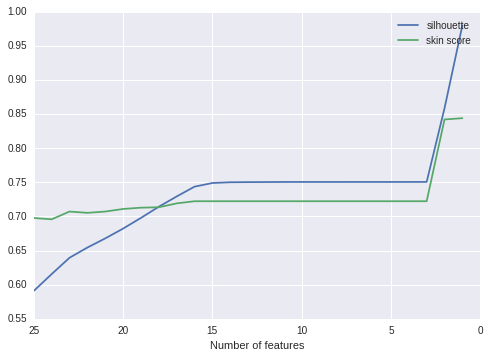

In [9]:
length = range(len(data_train.columns) -1 , 0, -1)
plt.plot(length, silhouettes_scores, label='silhouette')
plt.plot(length, 1 - np.array(skin_scores)  , label = 'skin score')
plt.xlabel('Number of features')
plt.gca().invert_xaxis()
plt.legend()

# Observation of the results

We have seen that the best combinations of features that get the best silhouette score is: **[seExp]** alone Remember that **seExp** is the mean of the standard error of each entries in the groupdby. Its corresponding silhouette score is around **0.98** that is a very high score (the best one is 1). It means that if we plot according to this features we should have 2 really strong communities. 

We have also seen that the error of classification decrease when the silhouette score increase and when we only keep seExp we get an accuracy of 85% which can seem very good. It could mean that the clustering of kmean is made based on the color skin. But we have to investigate a bit more the result to take such conclusions

First we must observe the cluster found is based only on seExp. So first we clusterise using only **seExp**

In [10]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=1)
kmeans.fit(data_agr.seExp.to_frame())
labels = kmeans.labels_

Then we plot the point according to seExp with the center of the 2 clusters:
    - in white the points of the cluster 0 with the center in red
    - in black the points of the cluster 1 with the center in green

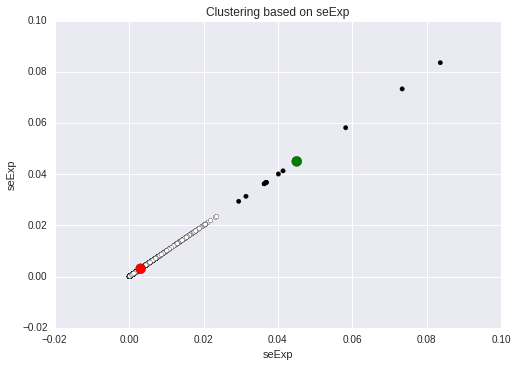

In [11]:
plt.scatter(data_agr.seExp, data_agr.seExp,c = labels)
plt.scatter(kmeans.cluster_centers_, kmeans.cluster_centers_, c = ['r', 'g'], s=100)
plt.title('Clustering based on seExp')
plt.ylabel('seExp')
plt.xlabel('seExp')

So first of all we can see that have "separate cluster". But it's not clear at all that we this 2 cluster return a silhouette score of 0.90. Let's rememenber what is the silhouette score (according to the documentation of sklearn): 

    -The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficent is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
 
We can see that SC (silhouette score) is maximum when $\frac{b-a}{max(a,b)} = 1$. It can only happen when $a = 0$ and $b>0$. If $a=0$, it's mean that the mean intra-cluster distance is 0. It doesn't look that way when we just see the graph above.

With this graph it's not possible to see the concentration of point in each cluster. So let's plot an histogram to see the distribution of each cluster
    

Number of elements in cluster 0: 1573  (99.24%)
Number of elements in cluster 0: 12  (0.76%)


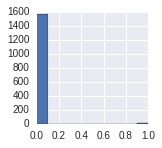

In [12]:
plt.figure(figsize=(2,2))
plt.hist(labels)
print('Number of elements in cluster 0: {}  ({:.2f}%)'.format(len(labels[labels == 0]) ,len(labels[labels == 0]) / len(labels) * 100))
print('Number of elements in cluster 0: {}  ({:.2f}%)'.format(len(labels[labels == 1]) ,len(labels[labels == 1]) / len(labels) * 100))


Ok so almost all the point are in the cluster 0

Now have a look at the distribution of the point in the cluster 0

(array([ 976.,  245.,  180.,   76.,   18.,   24.,   22.,   18.,   11.,    3.]),
 array([  3.18847017e-05,   2.38021766e-03,   4.72855062e-03,
          7.07688358e-03,   9.42521653e-03,   1.17735495e-02,
          1.41218824e-02,   1.64702154e-02,   1.88185484e-02,
          2.11668813e-02,   2.35152143e-02]),
 <a list of 10 Patch objects>)

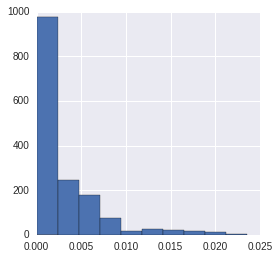

In [13]:
plt.figure(figsize=(4,4))
plt.hist(data_agr[labels == 0].seExp)

We have a lot of point concentrate close to 0. Let's see what is the value of the center of the cluster 0:
   

In [14]:
kmeans.cluster_centers_[0]

array([ 0.00310136])

Almost all the points are close to the center so the cluster 0 is almost represented by one point then this is why we have such a high silhouette score

## Accuracy

Now have a look at the accuracy that seems pretty good

In [15]:
colors = data_agr.color_rating
print('Arruracy: {:.2f} %'.format( 100- wrong_pred(colors, labels) * 100))

Arruracy: 84.61 %


Remember that we assume that a player with color rating N (value 3 in our case) cannot be misclusterised since we can't determined if it is more white or more black'. So let's see the distribution of white, neutral and black people

Proportion of White: 74.95%
Proportion of Neutral: 9.40%
Proportion of Black: 15.65%


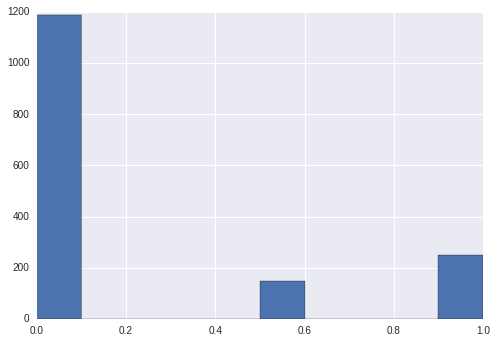

In [16]:
colors3 = colors.apply(lambda x: mapping(x))
plt.hist(colors3)
print('Proportion of White: {:.2f}%'.format(len(colors3[colors3==0]) / len(colors3) * 100))
print('Proportion of Neutral: {:.2f}%'.format(len(colors3[colors3==0.5]) / len(colors3) * 100))
print('Proportion of Black: {:.2f}%'.format(len(colors3[colors3==1]) / len(colors3) * 100))

So now imagine a clustering methods that create 2 clusters, 1 cluster White with all player and one empty cluster Black. The accuracy of will be : 85% (74.95 + 9.40). So the same accuracy that kmeans return us

# Conclusion

Even if the silhouette score is high (close to 0.98) and the accuracy of this clustering is 85% we can not say that kmeans clusterised the player according to the color skin since a constant method (as explain above) will achieve the same accuracy. Actually it is almost what did Kmeans since it put 99% of the data in the first cluster.